#### Post Processing techniques 
* this part of notebook will go for most uses Processsing Techniques used in ML PIPLINES 
  * through this implementation will over :
    - corredinte Voxel and Corrdinate Physical mapping in between 
    - Resampling 
    - resize
    - Normalization and standirzation 
    - Translation Geometry 


In [75]:
%matplotlib notebook
import nibabel as nib
import matplotlib.pyplot as plt 
import numpy as np
import SimpleITK as sitk
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel.processing as Resize 


The affine matrix describes the mapping from the pixel coordinates to the scanner (or world) coordinates: <br />
It is always a $4 \times 4$ matrix with the following scheme':

\begin{equation}\label{eq:appendrow}
  \left(\begin{array}{cccc}
    \color{red}{x_{1,1}}  & \color{red}{x_{1,2}}  & \color{red}{x_{1,3}} & \color{blue}{x_{1,4}} \\
    \color{red}{x_{2,1}}  & \color{red}{x_{2,2}}  & \color{red}{x_{2,3}} & \color{blue}{x_{1,4}} \\
    \color{red}{x_{3,1}}  & \color{red}{x_{3,2}}  & \color{red}{x_{3,3}} & \color{blue}{x_{1,4}} \\
    \color{red}{0}  & \color{red}{0}  & \color{red}{0} & \color{blue}{1} \\
  \end{array}\right)
\end{equation}

The $\color{red}{\text{red}}$, $3\times 3$ sub-matrix is responsible for rotation, scaling and shearing the coordinates.

The $\color{blue}{\text{blue}}$ vector is responsible for the translation or the offset.
The last row and column of the matrix is added for convenience, because it allows us to directly compute the transformation between the coordinate system in a single step instead of 2.


In [32]:
path_image = "03-Data-Formats/6_coro__corcta__06__i26f__2__70.nii.gz"
heart_ct = nib.load(path_image)
affine_data = heart_ct.get_fdata() ### access to data array of the Volume 
affine_corrd = heart_ct.affine ## the matrix that reperesnt the all Transformation Geomtry of Image 
Voxel_size = heart_ct.header.get_zooms() ## the corrdinate Axes of the Image 
print(f"shape of image is : {affine_data.shape}\n and affine Voxel corrd are :{affine_corrd[:3,3:]}\n {Voxel_size}")

shape of image is : (512, 512, 489)
 and affine Voxel corrd are :[[  54.33886719]
 [ 103.66113281]
 [-258.5       ]]
 (0.32226562, 0.32226562, 0.3)


You can slice through the volume in all orientations: axial, coronal and sagittal.<br />
**NOTE: Depending on the orientation of the scan, the indices change**<br />
Sometimes the first axis slices axial, sometimes coronal and sometimes sagittal.

You can find out the orientation by using **nib.aff2axcodes(affine)**
Remember the anatomical orientation from the medical introduction

In [33]:
nib.aff2axcodes(affine_corrd)

('L', 'A', 'S')

In [41]:
voxel_coord = np.array((0, 0, 0, 1))
physical_coord0 = affine_corrd @ voxel_coord  # @ is a shortcut for matrix multiplication in numpy
print(physical_coord0)

[  54.33886719  103.66113281 -258.5           1.        ]


In [42]:
voxel_coord_manual = np.array((0, 0, 0))
physical_coord_manual = affine_corrd[:3, :3] @ voxel_coord_manual
physical_coord_manual = physical_coord_manual + affine_corrd[:3,3]
print(physical_coord_manual)

[  54.33886719  103.66113281 -258.5       ]


If you want to transform physical coordinates into pixel/voxel coordinates you need to compute the inverse of the affine matrix (**np.linalg.inv(arr)** and then multiply this inverse with the physical coordinates.
As an example, if we want to get the voxel coordinates of our offset<br /> ( -90.67985535  102.82944489 -114.82378387
) we need to perform the following calculation:

In [43]:
voxel_coords = (np.linalg.inv(affine_corrd) @ physical_coord0).round()
print(voxel_coords)

[0. 0. 0. 1.]


#### Resampling Imaage 
***What is resampling vs resizing?***<br>
Summary.: <br>
  * Image resizing keeps the number of pixels in your image the same and affects only how large your image will print (the Document Size). Image resampling physically changes the number of pixels in your image (the Pixel Dimensions)

In [96]:
print(heart_ct.shape)
print(heart_ct.header.get_zooms())

(512, 512, 489)
(0.32226562, 0.32226562, 0.3)


In [124]:
voxel_size = (1,1,1)
target_size = (120,120,120)
resize_image = Resize.conform(heart_ct,target_size,voxel_size,orientation="LAS")
print(resize_image.shape)
array_from_image = resize_image.get_fdata()
new_thresholding = array_from_image * (array_from_image > 30)

(120, 120, 120)


In [138]:
image_f_array = nib.Nifti1Image(new_thresholding,resize_image.affine)


<IPython.core.display.Javascript object>


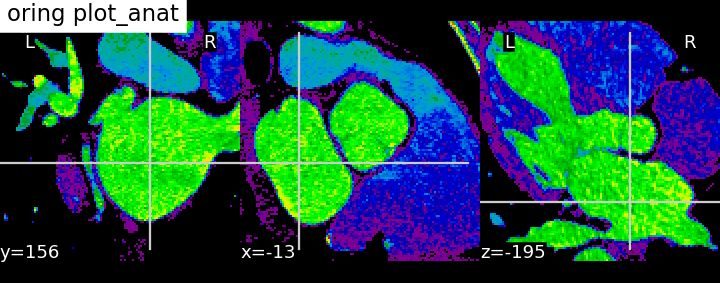

In [139]:
nlplt.plot_epi(image_f_array ,title='oring plot_anat')
plt.show()

<IPython.core.display.Javascript object>


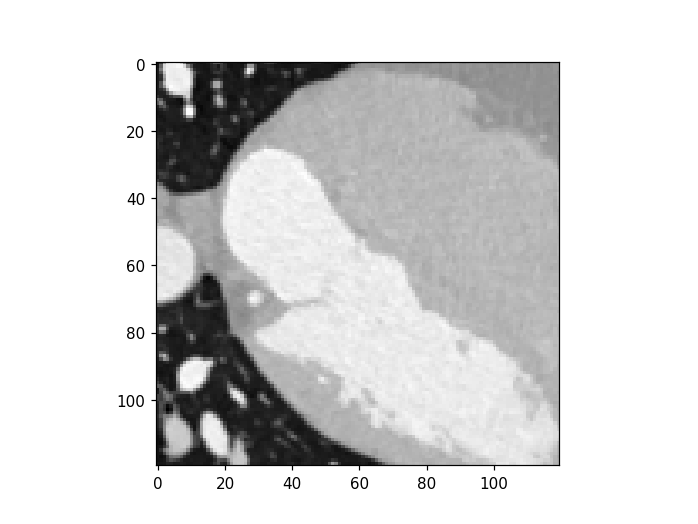

In [65]:
plt.imshow(new_thresholding[:,:,1],cmap="gray")

###### Standrization and Normalization 
As CTs have a fixed scale from -1000 (air) to 1000 (water) (This is called Houndsfield unit) you normally do not perform normalization to keep those scales.

In practice, you can assume that the values are between -1024 and 3071.

In [71]:
stander_image = array_from_image / 3071

<IPython.core.display.Javascript object>


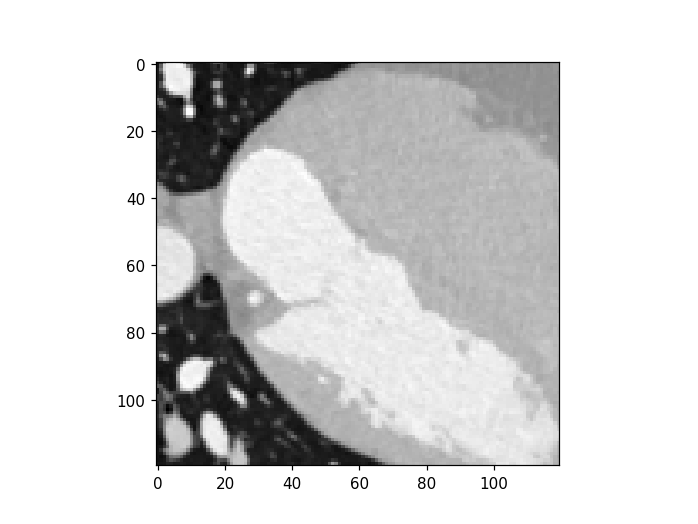

In [73]:
plt.figure()
plt.imshow(stander_image[:,:,30],cmap="gray")